In [382]:
# Authors: Rahul Ramachandran and Rishit D

# Importing the required libraries
try:
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score
    import scipy
    import matplotlib.pyplot as plt
except:
    print(f'[INFO] Installing the required libraries')
    %pip install numpy, pandas, scikit-learn, scipy, matplotlib
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score
    from scipy.stats import poisson
    import matplotlib.pyplot as plt

# Poisson Regression
[Poisson Regression](https://en.wikipedia.org/wiki/Poisson_regression) is a linear generalized model where we assume that the output is modelled from a Poisson distribution. We assume that probabilities take the following form:

$$ P(y=y_i|\lambda) = \frac{\lambda^{y_i}}{e^{\lambda}y_i!}$$

Consequently, our log likelihood $l$ takes the form:

$$ l(\lambda|y_i)  = \sum_{i=1}^n (y_i ln(\lambda) - \lambda - ln(y_i!)) $$

In the Poisson regression model, we work under the assumption that $𝔼[y_i|x_i] = \lambda_i = e^{x_i^T\theta}$, giving us the new expression for the log likelihood as follows:

$$ l(\theta|y_i, X_i) = \sum_{i=1}^n (y_i X_i^T \theta - e^{X_i^T \theta} - ln(y_i!)) $$

Now the gradient of the log-likelihood with respect to the parameter vector $\theta$:

$$ \nabla_\theta l(\theta|y_i, X_i) = \sum_{i=1}^n (y_i - e^{X_i^T \theta})X_i $$


## Rationale Behind Model
- One motivating factor for choosing the Poisson Distribution was the positive support; the predicted times cannot be negative, so using a Gaussian distribution wouldn't work as well. 
- The discrete nature of the Poisson RV is also helpful in this case, as time is being measured by the minute (and can hence be treated as discrete).
- In addition to this, the shape of the distribution of durations seems to resemble a Poisson.

In [383]:
from typing import List

class PoissonRegression:

    def __init__(self, dim:int, alpha:float=0.01, n_iter:int=1000, lambda_:float=0.1, weights:np.ndarray=None):
        """
            dim: Dimension of the data
            alpha: Learning rate
            n_iter: Max Number of iterations
            lambda_: Regularization parameter
            weights: Initial weights
        """
        if weights is not None:
            self.theta = weights # If weights provided, use them
            assert self.theta.shape == (dim+1, 1)
        else:
            self.theta = np.zeros((dim+1, 1)) # include the bias term
        self.alpha = alpha
        self.n_iter = n_iter
        self.lambda_ = lambda_
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        """Fits the model (theta) to the data
            params:
                X: shape = (n, dim)
                y: shape = (n, 1)
            returns:
                List of losses
                Weight vector theta
        """
        losses = []

        # Concatenate a column of ones to X
        X_c = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1) # shape = (n, dim+1)

        for iter in range(self.n_iter):
            # Calculate the loss (ignore the constant factorial term)
            loss = -np.sum(y * (X_c @ self.theta) - np.exp(X_c @ self.theta)) + self.lambda_ * np.sum(self.theta**2)
            losses.append(loss)

            # Update theta (gradient descent)
            self.theta -= -self.alpha * (X_c.T @ (y - np.exp(X_c @ self.theta))) + 2 * self.lambda_ * self.theta
        
        return losses, self.theta
    
    def predict(self, X:np.ndarray)->np.ndarray:
        """Predicts the response variable
            params:
                X: shape = (n, dim)
            returns:
                y_pred: shape = (n, 1)
        """
        # Concatenate a column of ones to X
        X_c = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        y_pred = np.exp(X_c @ self.theta)
        return y_pred

In [384]:
# Custom cross-validation for Poisson Regression
def cross_val_poisson(data, cv=5):
    """Performs cross-validation
        params:
            data: Dataframe
            cv: Number of folds
        returns:
            List of negative mean absolute errors
    """
    # Generate cross-val folds
    folds = np.array_split(data, cv)
    nmaes = []
    for i in range(cv):
        # Split into train and test
        test = folds[i]
        train = pd.concat([folds[j] for j in range(cv) if j != i])
        X_train, y_train = train[["Day","Start", "Category","Company","Ordered","Event After"]].to_numpy(), train[["Duration"]].to_numpy()
        X_test, y_test = test[["Day","Start", "Category","Company","Ordered","Event After"]].to_numpy(), test[["Duration"]].to_numpy()

        # Scale
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit the model
        model = PoissonRegression(dim=6, alpha=1e-7, n_iter=100000, lambda_=1e-8, weights=np.array([[1., 0., 0., 0., 1., 1., -1.]]).T)
        losses, theta = model.fit(X_train, y_train)
        
        y_pred_pos = poisson.predict(X_test)
        nmae = -np.mean(np.abs(y_pred_pos - y_test))
        nmaes.append(nmae)
        
    return nmaes

## Rationale behind Data Features
The features selected are known to influence eating times ("Day","Start", "Category","Company","Ordered","Event After"). 
- The day of the week is a common feature, and was provided in the problem description
- The category (breakfast/lunch/dinner) is another trivial feature
- It is generally observed that eating out / ordering / eating with friends increases eating times. This lead to the inclusion of features like "Company", "Ordered" and "Event After".

In [385]:
# Get data from the csv file
df = pd.read_csv('final_data.csv')

# Randomly select 80% of the data for training
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)
X_train, y_train = np.array(train[["Day","Start", "Category","Company","Ordered","Event After"]]), np.array(train["Duration"])[:, np.newaxis]
X_test, y_test = np.array(test[["Day","Start", "Category","Company","Ordered","Event After"]]), np.array(test["Duration"])[:, np.newaxis]

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60, 6) (60, 1) (15, 6) (15, 1)


Model weights: [ 3.37318097  0.01722933 -0.03512211 -0.0332497   0.22116469  0.10608351
 -0.05456518]
Mean Absolute Error: 3.3049324573327956
Mean Squared Error: 21.321301403452445


/home/vader/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Cross Validation MAE (averaged over 5 runs): 3.3647729978677186


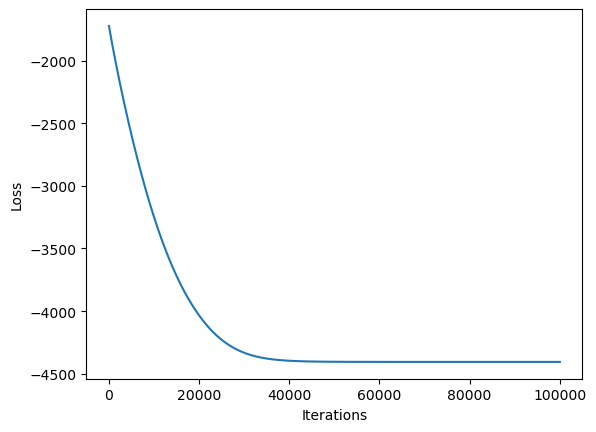

In [386]:
# Fit the model
poisson = PoissonRegression(dim=6, alpha=1e-7, n_iter=100000, lambda_=1e-8, weights=np.array([[1., 0., 0.5, 0., 1., 1., -1.]]).T)
losses, weights = poisson.fit(X_train, y_train)

# Plot the losses
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
print(f'Model weights: {weights.T[0]}')

y_pred_pos = poisson.predict(X_test)

# Find mean absolute error on the test set
mae = np.mean(np.abs(y_pred_pos - y_test))
print(f'Mean Absolute Error: {mae}')

# Find mean squared error on the test set
mse = np.mean((y_pred_pos - y_test)**2)
print(f'Mean Squared Error: {mse}')

# Perform cross-validation
nmaes = cross_val_poisson(df, cv=5)
print(f'Cross Validation MAE (averaged over 5 runs): {-np.mean(nmaes)}')

In [387]:
# Fit linear regression
linear = LinearRegression()
vals = linear.fit(X_train, y_train)
# print(vals.coef_, vals.intercept_)
y_pred_lin = linear.predict(X_test)

# Find mean absolute error on the test set
mae = np.mean(np.abs(y_pred_lin - y_test))
print(f'Mean Absolute Error: {mae}')
# Find mean squared error on the test set
mse = np.mean((y_pred_lin - y_test)**2)
print(f'Mean Squared Error: {mse}')

# Cross-validate
cv_results = cross_val_score(linear, train[["Day","Start", "Category","Company","Ordered","Event After"]], train["Duration"], cv=5, scoring='neg_mean_absolute_error')
print(f'Cross Validation MAE (averaged over 5 runs): {-np.mean(cv_results)}')

Mean Absolute Error: 3.4791051273180127
Mean Squared Error: 23.38674534345299
Cross Validation MAE (averaged over 5 runs): 3.7813704969180693


# Summary

The results are summarised in the table below:
| Model | MAE | MSE | Averaged MAE |
| --- | --- | --- | --- |
| Linear Regression | 3.48 | 23.39 | 3.78 |
| Poisson Regression | 3.30 | 21.32 | 3.36 |

The Poisson Regression Model outperforms the Linear Regression Model, and thus demonstrates its suitability for the task.

## Analysis of Weights
The weights obtained were: 


[[ 3.37318097]
 [ 0.01722933]
 [-0.03512211]
 [-0.0332497 ]
 [ 0.22116469]
 [ 0.10608351]
 [-0.05456518]]
 

This reveals some interesting patterns:
- The first number is the weight for the intercept, and is of no significance.
- The weight corresponding to `ordered` is positive, and reflects the positive correlation between ordering food and the duration.
- We observe that the weight corresponding to `company` is positive and has a relatively higher magnitude. This is also in-line with what we observed in the EDA. The weight corresponding to `event after` is negative.
- Another interesting thing to note is that the magnitudes of weights are lower for features (like start time) which seem uncorrelated with the duration.